In [1]:
%matplotlib inline
# -*- coding: utf-8 -*-
"""
Created on Fri Apr 22 17:25:13 2016

@author: tabacof
"""

# Implements a variational autoencoder as described in Kingma et al. 2013
# "Auto-Encoding Variational Bayes"
import theano
theano.config.floatX = 'float32'
import theano.tensor as T
import numpy as np
import lasagne
import time, shutil, os
import scipy
from scipy.io import loadmat
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import pylab as plt
from read_write_model import read_model, write_model

Using gpu device 1: GeForce GTX 980 (CNMeM is disabled, cuDNN 4007)


In [2]:
#settings
do_train_model = False
batch_size = 100
num_epochs = 50
model_filename = "svhn_conv_clf"

np.random.seed(1234) # reproducibility

In [3]:
print "Using SVHN dataset"

svhn_train = loadmat('train_32x32.mat')
svhn_test = loadmat('test_32x32.mat')

train_y = svhn_train['y'].flatten() - 1
test_y = svhn_test['y'].flatten() - 1

train_x = np.rollaxis(svhn_train['X'].copy(), 3).transpose(0,3,1,2).astype(theano.config.floatX)
test_x = np.rollaxis(svhn_test['X'].copy(), 3).transpose(0,3,1,2).astype(theano.config.floatX)

svhn_mean = 115.11177966923525
svhn_std = 50.819267906232888
train_x = (train_x - svhn_mean)/svhn_std
test_x = (test_x - svhn_mean)/svhn_std

input_var = T.tensor4('inputs')
target_var = T.ivector('targets')

Using SVHN dataset


In [4]:
relu = lasagne.nonlinearities.rectify

network = lasagne.layers.InputLayer(shape=(None, 3, 32, 32),input_var=input_var)
l_noise = lasagne.layers.BiasLayer(network, b = np.zeros((3,32,32), dtype = np.float32), shared_axes = 0, name = "NOISE")
l_noise.params[l_noise.b].remove("trainable")
network = lasagne.layers.Conv2DLayer(l_noise, num_filters=32, filter_size=(3, 3), nonlinearity=relu, pad = 'same')
network = lasagne.layers.Conv2DLayer(network, num_filters=32, filter_size=(3, 3), nonlinearity=relu)
network = lasagne.layers.MaxPool2DLayer(network, pool_size=(2, 2))
network = lasagne.layers.dropout(network, p=.25)
network = lasagne.layers.Conv2DLayer(network, num_filters=64, filter_size=(3, 3), nonlinearity=relu, pad = 'same')
network = lasagne.layers.Conv2DLayer(network, num_filters=32, filter_size=(3, 3), nonlinearity=relu)
network = lasagne.layers.MaxPool2DLayer(network, pool_size=(2, 2))
network = lasagne.layers.dropout(network, p=.25)
network = lasagne.layers.DenseLayer(network, num_units=512, nonlinearity=relu)
network = lasagne.layers.dropout(network, p=.5)
network = lasagne.layers.DenseLayer(network, num_units=10, nonlinearity=lasagne.nonlinearities.softmax)

In [5]:
prediction = lasagne.layers.get_output(network)
loss = lasagne.objectives.categorical_crossentropy(prediction, target_var)
loss = loss.mean()

params = lasagne.layers.get_all_params(network, trainable=True)
updates = lasagne.updates.nesterov_momentum(loss, params, 0.01, 0.9)

test_prediction = lasagne.layers.get_output(network, deterministic=True)
test_loss = lasagne.objectives.categorical_crossentropy(test_prediction,
                                                        target_var)
test_loss = test_loss.mean()
test_acc = T.mean(T.eq(T.argmax(test_prediction, axis=1), target_var),
                  dtype=theano.config.floatX)

train_fn = theano.function([input_var, target_var], loss, updates=updates)

val_fn = theano.function([input_var, target_var], [test_loss, test_acc])

In [6]:
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

In [7]:
if do_train_model:
    # Finally, launch the training loop.
    print("Starting training...")
    # We iterate over epochs:
    for epoch in range(num_epochs):
        # In each epoch, we do a full pass over the training data:
        train_err = 0
        train_batches = 0
        start_time = time.time()
        for batch in iterate_minibatches(train_x, train_y, batch_size, shuffle=True):
            tr_inputs, tr_targets = batch
            train_err += train_fn(tr_inputs, tr_targets)
            train_batches += 1

        # And a full pass over the validation data:
        val_err = 0
        val_acc = 0
        val_batches = 0
        for batch in iterate_minibatches(test_x, test_y, batch_size, shuffle=False):
            inputs, targets = batch
            err, acc = val_fn(inputs, targets)
            val_err += err
            val_acc += acc
            val_batches += 1

        # Then we print the results for this epoch:
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss:\t\t{:.6f}".format(train_err / train_batches))
        print("  validation loss:\t\t{:.6f}".format(val_err / val_batches))
        print("  validation accuracy:\t\t{:.2f} %".format(
            val_acc / val_batches * 100))
    write_model([network], model_filename)
else:
    read_model([network], model_filename)

Starting training...
Epoch 1 of 50 took 40.036s
  training loss:		1.351583
  validation loss:		0.549840
  validation accuracy:		83.85 %
Epoch 2 of 50 took 36.746s
  training loss:		0.534484
  validation loss:		0.407896
  validation accuracy:		88.10 %
Epoch 3 of 50 took 50.094s
  training loss:		0.434598
  validation loss:		0.365811
  validation accuracy:		89.18 %
Epoch 4 of 50 took 48.393s
  training loss:		0.385394
  validation loss:		0.314935
  validation accuracy:		91.12 %
Epoch 5 of 50 took 44.279s
  training loss:		0.357757
  validation loss:		0.304126
  validation accuracy:		91.19 %
Epoch 6 of 50 took 32.309s
  training loss:		0.336877
  validation loss:		0.282928
  validation accuracy:		92.13 %
Epoch 7 of 50 took 29.968s
  training loss:		0.316690
  validation loss:		0.279639
  validation accuracy:		92.11 %
Epoch 8 of 50 took 28.897s
  training loss:		0.303053
  validation loss:		0.259646
  validation accuracy:		92.69 %
Epoch 9 of 50 took 28.842s
  training loss:		0.293303
  val

In [8]:
def show_svhn(img, i, title=""): # expects flattened image of shape (3072,) 
    img = img.copy().reshape(3,32,32).transpose(1,2,0)
    img *= svhn_std
    img += svhn_mean
    img /= 255.0
    img = np.clip(img, 0, 1)
    plt.subplot(1, 2, i)
    plt.imshow(img)
    plt.title(title)
    plt.axis("off")
    plt.show()

In [9]:
# Adversarial confusion cost function
adv_confusion = lasagne.objectives.categorical_crossentropy(test_prediction, target_var).mean()

# Adversarial regularization
regC = T.scalar()
adv_reg = regC*lasagne.regularization.l2(l_noise.b)
# Total adversarial loss
adv_loss = adv_confusion + adv_reg
adv_grad = T.grad(adv_loss, l_noise.b)

# Function used to optimize the adversarial noise
adv_function = theano.function([input_var, target_var, regC], [adv_loss, adv_grad, test_prediction])

In [10]:
def adv_test(orig_img, adv_label, C, plot = True):
    # Set the adversarial noise to zero
    l_noise.b.set_value(np.zeros((3,32,32)).astype(np.float32))

    _, _, orig_pred = adv_function(test_x[orig_img][np.newaxis, :, :, :], [adv_label], C)

    # Initialize the adversarial noise for the optimization procedure
    l_noise.b.set_value(np.random.uniform(-1e-8, 1e-8, size=(3,32,32)).astype(np.float32))

    # Optimization function for L-BFGS-B
    def fmin_func(x):
        l_noise.b.set_value(x.reshape(3, 32, 32).astype(np.float32))
        f, g, _ = adv_function(test_x[orig_img][np.newaxis, :, :, :], [adv_label], C)
        return float(f), g.flatten().astype(np.float64)

    # Noise bounds (pixels cannot exceed 0-1)
    bounds = zip(-svhn_mean/svhn_std-test_x[orig_img].flatten(), (255.0-svhn_mean)/svhn_std-test_x[orig_img].flatten())

    # L-BFGS-B optimization to find adversarial noise
    x, f, d = scipy.optimize.fmin_l_bfgs_b(fmin_func, l_noise.b.get_value().flatten(), bounds = bounds, fprime = None, factr = 10, m = 25)
    l_noise.b.set_value(x.reshape(3, 32, 32).astype(np.float32))
    
    adv_loss, _, adv_pred = adv_function(test_x[orig_img][np.newaxis, :, :, :], [adv_label], C)

    if plot:
        plt.figure()
        show_svhn(test_x[orig_img], 1, "Original")
        show_svhn(test_x[orig_img] + x.reshape(3, 32, 32), 2, "Adversarial")
        plt.show()
            
    return adv_loss, np.linalg.norm(x), test_y[orig_img], np.argmax(orig_pred), np.argmax(adv_pred), adv_pred[0][test_y[orig_img]], adv_pred[0][adv_label]

In [11]:
def orig_adv_dist(orig_img = None, plot = False):
    if orig_img is None:
        orig_img = np.random.randint(0, len(test_x))
        _, _, pred = adv_function(test_x[orig_img][np.newaxis, :, :, :], [0], 0.0)
        print(np.argmax(pred), test_y[orig_img], pred)
        while np.argmax(pred) != test_y[orig_img]:
            orig_img = np.random.randint(0, len(test_x))
            _, _, pred = adv_function(test_x[orig_img][np.newaxis, :, :, :], [0], 0.0)

    adv_label = test_y[orig_img]
    while adv_label ==  test_y[orig_img]:
        adv_label = np.random.randint(0, 10)
        
    print "Img",orig_img, "Adv label", adv_label
    
    adv_loss=[]
    adv_norm=[]
    orig_prob=[]
    adv_prob=[]
    adv = []
    
    C = np.logspace(-10, 20, 50, base = 2, dtype = np.float32)
    
    for c in C:
        od, ad, ol, op, ap, o_prob, a_prob = adv_test(orig_img, adv_label, C=c, plot = False)
        #print od, ad, ol+1, op+1, ap+1
        adv_loss.append(od)
        adv_norm.append(ad)
        adv.append(ap == adv_label)
        orig_prob.append(o_prob)
        adv_prob.append(a_prob)
        
    adv_loss = np.array(adv_loss)
    adv_norm = np.array(adv_norm)

    if plot:
        plt.figure()
        plt.scatter([adv_norm[i] for i, x in enumerate(adv) if x], [adv_loss[i] for i, x in enumerate(adv) if x], c='red', label = "Adversarial")
        plt.scatter([adv_norm[i] for i, x in enumerate(adv) if not x], [adv_loss[i] for i, x in enumerate(adv) if not x], c='blue', label = "Non-adversarial")
        plt.ylabel("Adversarial cross-entropy")
        plt.xlabel("Adversarial distortion")
        plt.legend(loc=3, prop={'size':9})
        plt.show()
        plt.figure()
        plt.scatter([adv_norm[i] for i, x in enumerate(adv) if x], [adv_prob[i] for i, x in enumerate(adv) if x], c='orange', label = "Adversarial Adv")
        plt.scatter([adv_norm[i] for i, x in enumerate(adv) if not x], [adv_prob[i] for i, x in enumerate(adv) if not x], c='cyan', label = "Non-adversarial Adv")
        plt.scatter([adv_norm[i] for i, x in enumerate(adv) if x], [orig_prob[i] for i, x in enumerate(adv) if x], c='red', label = "Adversarial Orig")
        plt.scatter([adv_norm[i] for i, x in enumerate(adv) if not x], [orig_prob[i] for i, x in enumerate(adv) if not x], c='blue', label = "Non-adversarial Orig")
        plt.ylabel("Probability")
        plt.xlabel("Adversarial distortion")
        plt.legend(loc=3, prop={'size':9})
        plt.show()
        plt.figure()
        plt.scatter([adv_norm[i] for i, x in enumerate(adv) if x], [scipy.special.logit(adv_prob[i]) for i, x in enumerate(adv) if x], c='orange', label = "Adversarial Adv")
        plt.scatter([adv_norm[i] for i, x in enumerate(adv) if not x], [scipy.special.logit(adv_prob[i]) for i, x in enumerate(adv) if not x], c='cyan', label = "Non-adversarial Adv")
        plt.scatter([adv_norm[i] for i, x in enumerate(adv) if x], [scipy.special.logit(orig_prob[i]) for i, x in enumerate(adv) if x], c='red', label = "Adversarial Orig")
        plt.scatter([adv_norm[i] for i, x in enumerate(adv) if not x], [scipy.special.logit(orig_prob[i]) for i, x in enumerate(adv) if not x], c='blue', label = "Non-adversarial Orig")
        plt.ylabel("Logit")
        plt.xlabel("Adversarial distortion")
        plt.legend(loc=3, prop={'size':9})
        plt.show()
        
    return adv_norm, adv_loss, adv_prob, orig_prob

(4, 4, array([[  1.75442165e-05,   5.53837971e-08,   1.49865274e-03,
          9.90408822e-08,   9.98450518e-01,   1.85048757e-05,
          2.39779126e-07,   4.57504893e-06,   9.78217849e-06,
          5.95786496e-08]], dtype=float32))
Img 25463 Adv label 0


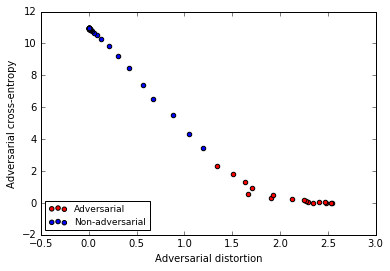

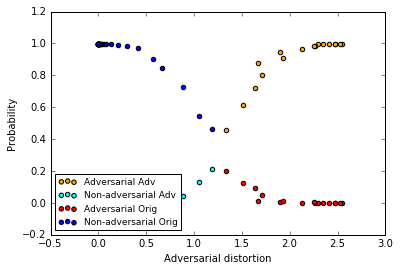

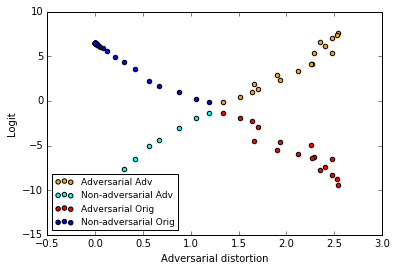

(0, 0, array([[  9.98107076e-01,   9.17522993e-06,   2.39885208e-04,
          1.11718872e-03,   3.02494416e-04,   9.17121652e-05,
          2.44173862e-06,   1.09159388e-04,   1.90982610e-05,
          1.76380991e-06]], dtype=float32))
Img 23425 Adv label 2


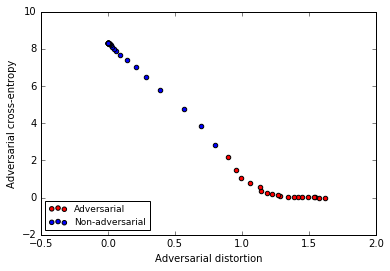

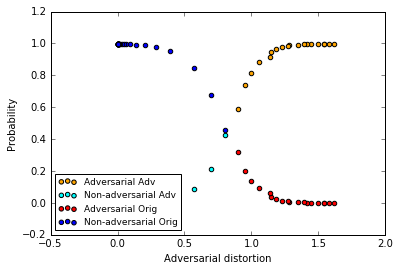

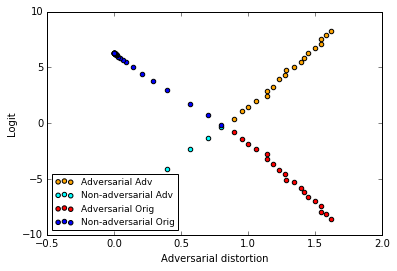

(6, 6, array([[  1.05831271e-06,   1.06900843e-05,   5.51531627e-07,
          2.32041095e-10,   8.69508021e-10,   4.68171023e-11,
          9.99987721e-01,   4.82379414e-10,   4.68501611e-08,
          2.41245860e-11]], dtype=float32))
Img 20825 Adv label 9


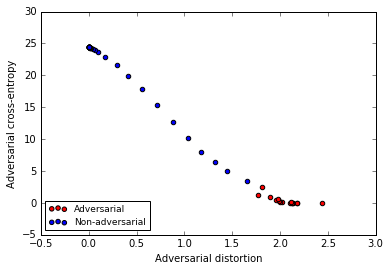

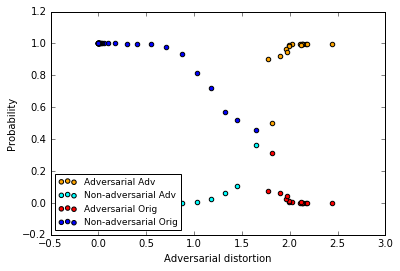

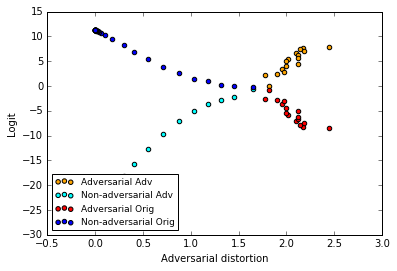

(9, 9, array([[  2.67404523e-12,   7.17066939e-08,   2.02841591e-10,
          1.63585534e-11,   1.49800514e-13,   3.10459063e-06,
          2.23117683e-12,   3.19887086e-08,   1.05648553e-06,
          9.99995708e-01]], dtype=float32))
Img 1264 Adv label 6


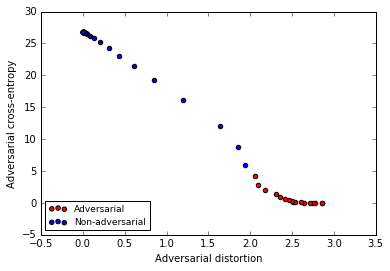

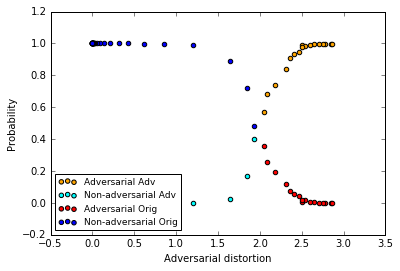

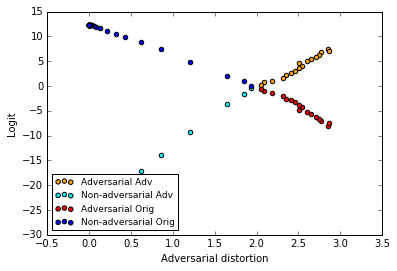

(0, 0, array([[  9.99451578e-01,   1.01899408e-04,   8.82294728e-07,
          6.48749210e-06,   1.37357343e-08,   3.34822244e-06,
          3.77465301e-04,   1.42456865e-05,   1.79881681e-05,
          2.61642945e-05]], dtype=float32))
Img 9006 Adv label 1


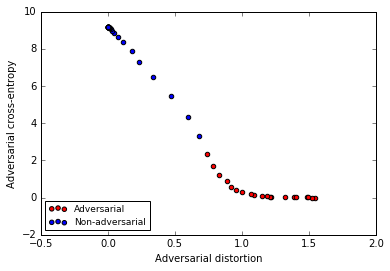

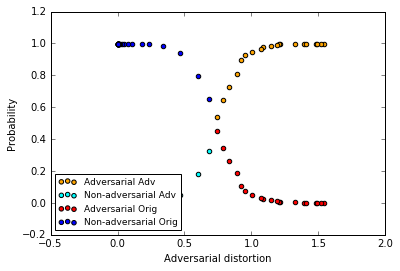

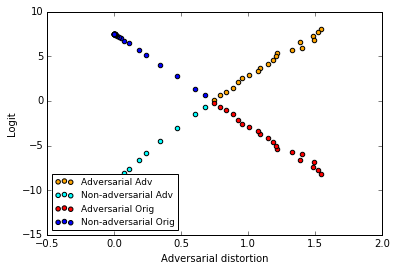

(2, 2, array([[  1.43386035e-06,   2.14363467e-07,   9.99988794e-01,
          4.53898863e-10,   9.55859832e-06,   1.88783211e-08,
          1.70798646e-08,   4.44444659e-08,   3.83409554e-10,
          4.91479835e-09]], dtype=float32))
Img 21863 Adv label 7


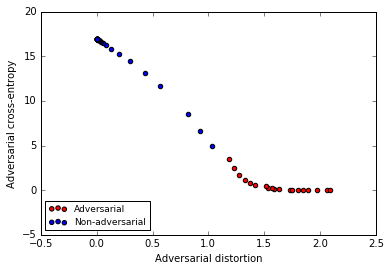

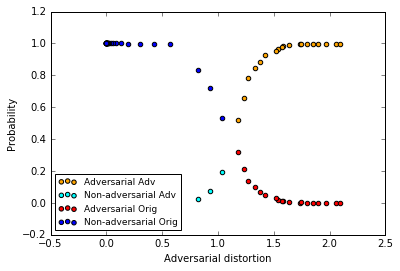

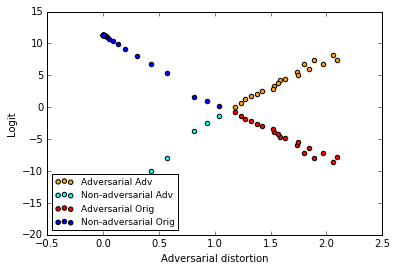

(0, 0, array([[  9.99711812e-01,   1.36557079e-04,   8.58771455e-05,
          6.52807503e-05,   7.19676052e-08,   4.49064952e-10,
          1.92645942e-07,   3.16484901e-08,   1.48765551e-08,
          4.26619939e-09]], dtype=float32))
Img 20650 Adv label 8


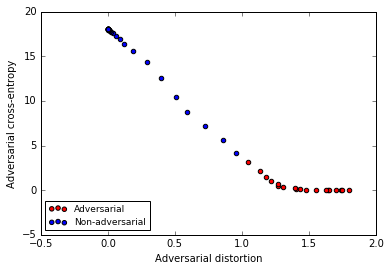

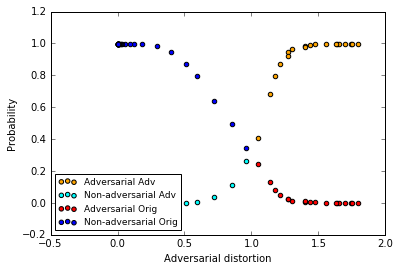

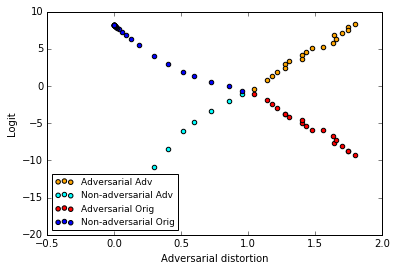

(1, 1, array([[  1.45077781e-08,   9.99995351e-01,   3.57881675e-07,
          7.37850655e-07,   2.76430774e-06,   1.69311871e-08,
          1.23548048e-07,   2.60523964e-11,   8.22882917e-09,
          7.31174509e-07]], dtype=float32))
Img 6910 Adv label 9


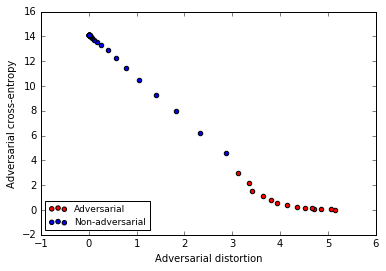

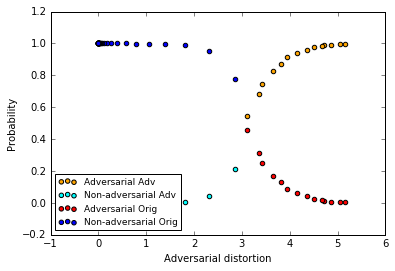

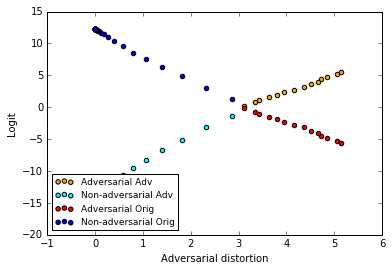

(0, 0, array([[  9.99048412e-01,   4.55215377e-05,   1.07162494e-04,
          1.84030854e-04,   5.22229413e-07,   7.27409770e-06,
          4.53814951e-04,   1.00359255e-04,   2.15051074e-07,
          5.26120202e-05]], dtype=float32))
Img 19794 Adv label 4


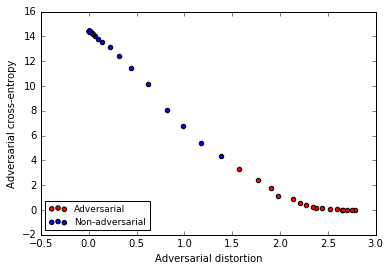

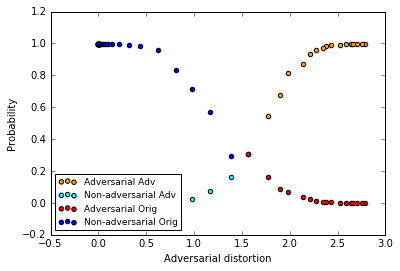

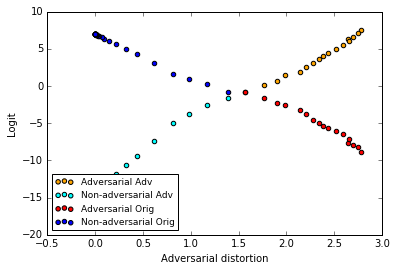

(9, 9, array([[  3.40652491e-07,   1.64828762e-07,   8.28730492e-07,
          1.69893980e-07,   6.25237861e-09,   1.35924529e-05,
          9.28525079e-09,   1.26463892e-05,   2.56803323e-05,
          9.99946594e-01]], dtype=float32))
Img 181 Adv label 2


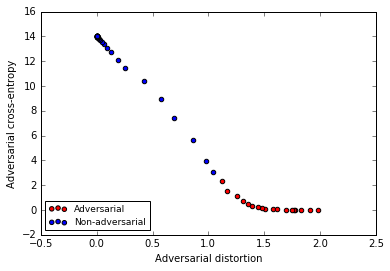

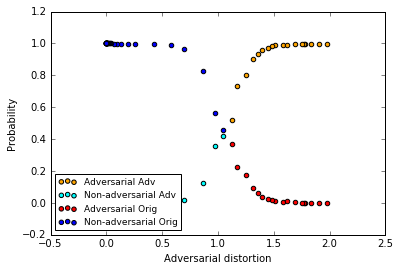

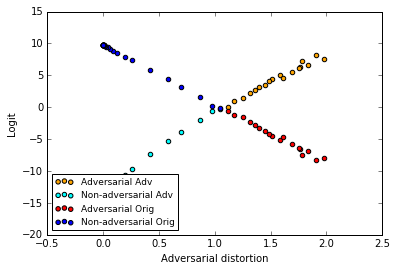

(4, 4, array([[  3.70363523e-05,   5.80008873e-07,   8.09887013e-07,
          1.76780119e-08,   9.99836683e-01,   1.22988411e-06,
          1.05804225e-04,   2.59365063e-08,   1.77035618e-05,
          5.74515582e-08]], dtype=float32))
Img 19762 Adv label 8


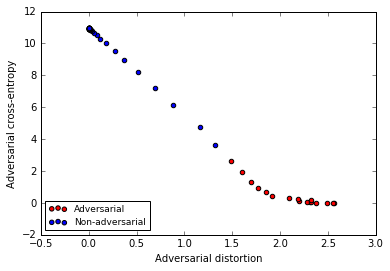

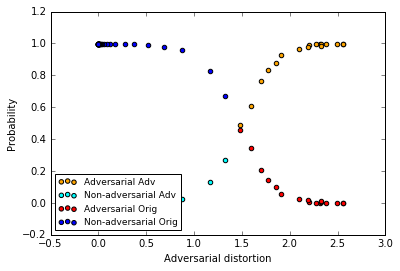

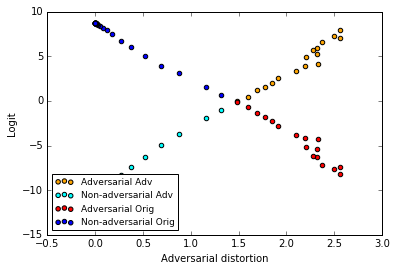

(9, 9, array([[  6.93491976e-13,   4.52645388e-08,   8.08625042e-11,
          7.07755122e-12,   1.68846115e-09,   1.33510481e-03,
          2.91367442e-14,   1.47327984e-04,   2.53509074e-06,
          9.98514950e-01]], dtype=float32))
Img 21405 Adv label 0


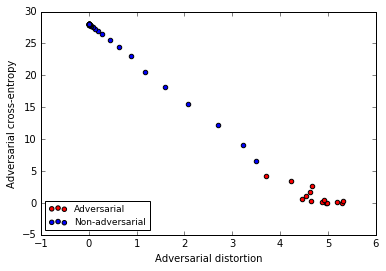

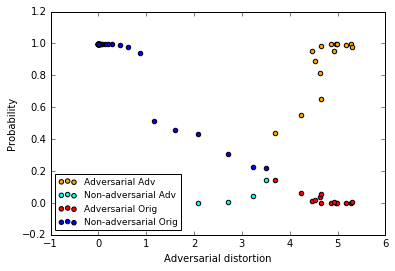

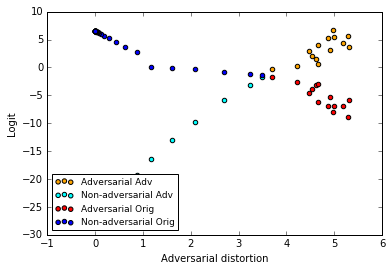

(3, 3, array([[  7.84202386e-03,   3.49227739e-05,   1.70401868e-03,
          9.86722887e-01,   1.25603519e-05,   9.46573437e-06,
          2.25692842e-04,   1.14839931e-04,   2.53158575e-03,
          8.02149589e-04]], dtype=float32))
Img 23447 Adv label 2


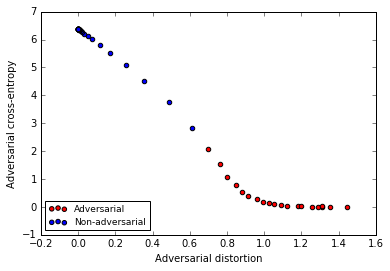

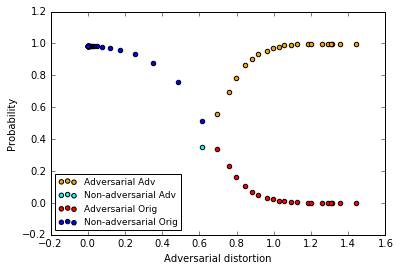

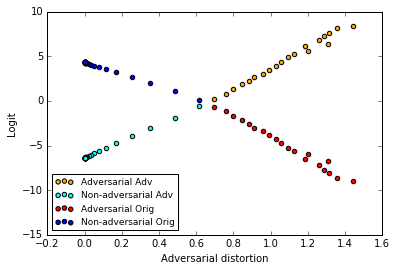

(4, 4, array([[  2.36499662e-04,   3.26918848e-06,   1.66872974e-06,
          1.18287993e-07,   9.99684989e-01,   8.51463392e-06,
          2.73224578e-05,   6.55519514e-08,   3.59475998e-05,
          1.54358747e-06]], dtype=float32))
Img 21424 Adv label 3


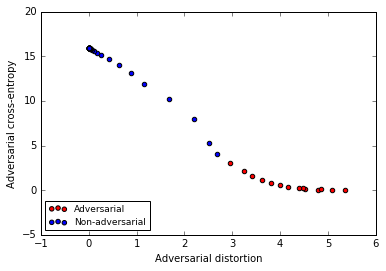

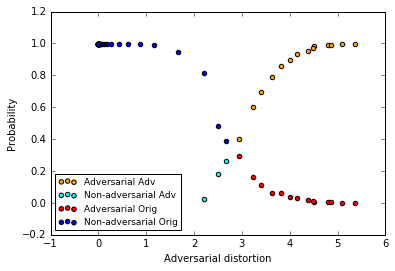

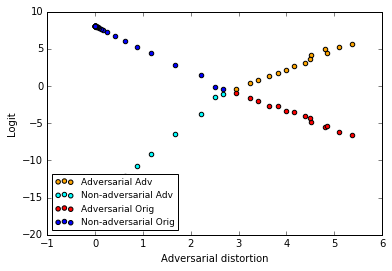

(0, 0, array([[  9.98164117e-01,   1.00068401e-05,   3.93935443e-06,
          1.61238678e-03,   1.64711746e-05,   6.20582796e-05,
          1.41913802e-06,   1.21581819e-04,   2.76799642e-06,
          5.24077632e-06]], dtype=float32))
Img 10278 Adv label 4


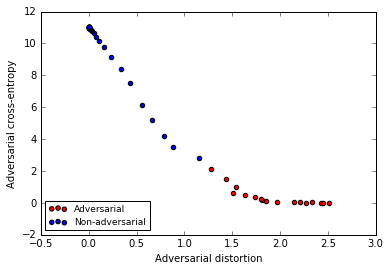

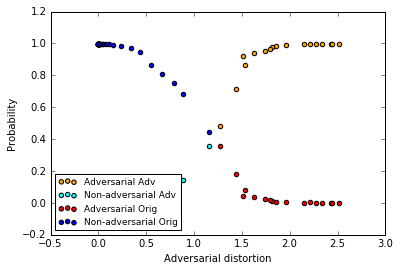

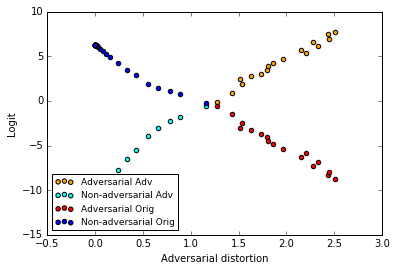

(0, 0, array([[  9.99982357e-01,   3.54468788e-09,   1.65331826e-07,
          1.73153530e-05,   6.76537084e-08,   1.30294717e-08,
          1.17630510e-08,   6.46604832e-08,   9.41917877e-10,
          1.15172349e-09]], dtype=float32))
Img 16019 Adv label 8


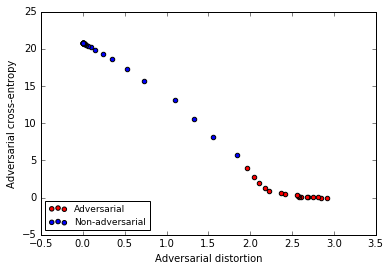

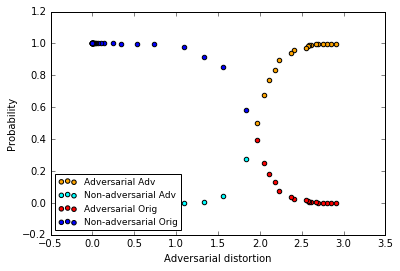

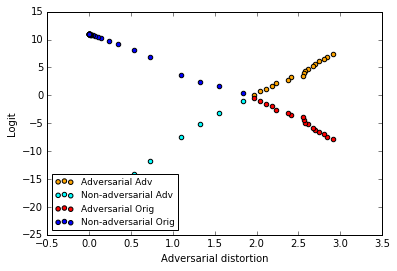

(0, 0, array([[  9.99986529e-01,   1.98885164e-06,   3.36770171e-07,
          1.49686241e-06,   1.16742482e-08,   7.25631821e-08,
          8.43709313e-06,   2.35995614e-07,   3.07911705e-07,
          3.99994718e-07]], dtype=float32))
Img 4151 Adv label 5


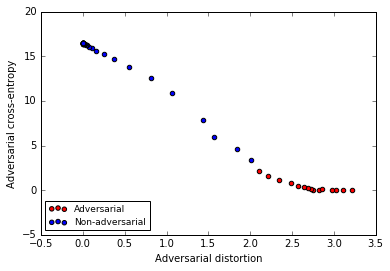

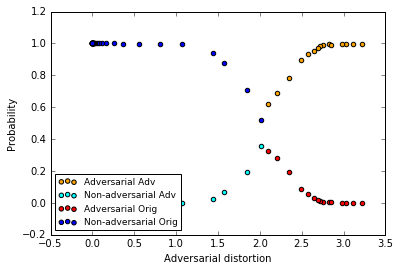

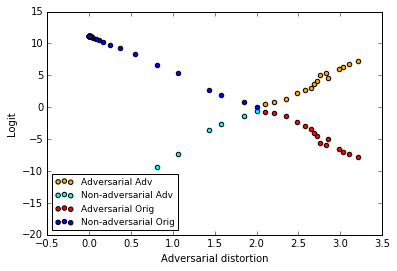

(1, 1, array([[  4.40538442e-03,   9.68702614e-01,   1.00232353e-02,
          2.56475760e-04,   1.31411391e-04,   1.45141571e-03,
          1.23188207e-02,   1.58235431e-03,   9.93839349e-04,
          1.34410235e-04]], dtype=float32))
Img 6796 Adv label 9


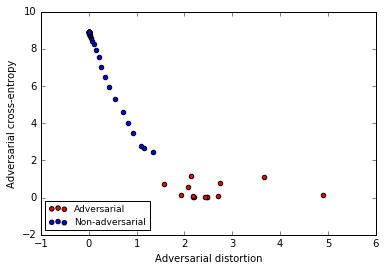

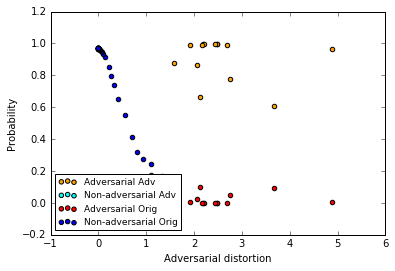

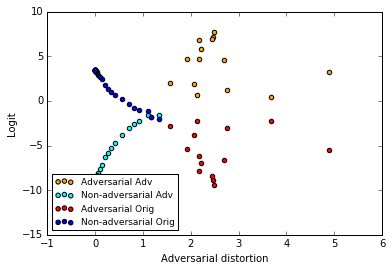

(7, 7, array([[  2.16776301e-04,   2.97947461e-03,   3.03793829e-02,
          5.23582974e-04,   1.09750731e-03,   1.27657533e-01,
          3.41464438e-05,   7.63818204e-01,   1.82990450e-02,
          5.49943745e-02]], dtype=float32))
Img 13271 Adv label 3


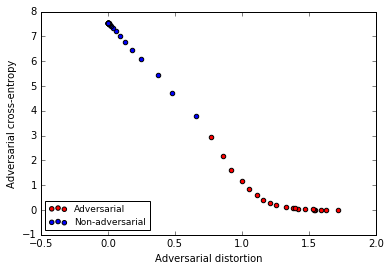

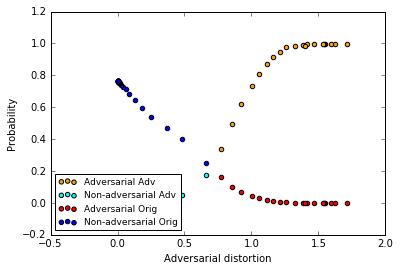

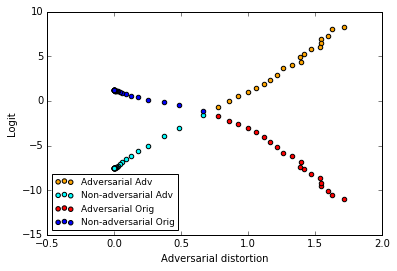

(7, 7, array([[  5.16875181e-04,   1.23312464e-04,   2.81407265e-04,
          2.45224597e-04,   6.25077228e-04,   2.52728220e-02,
          1.06118860e-05,   9.58915055e-01,   1.22313127e-02,
          1.77826232e-03]], dtype=float32))
Img 6692 Adv label 3


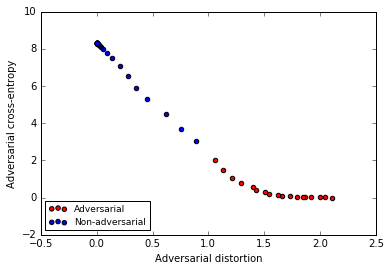

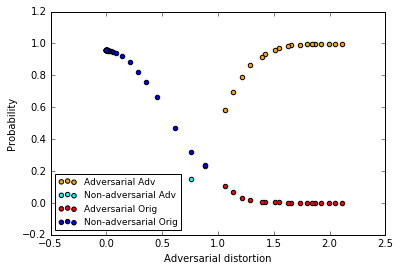

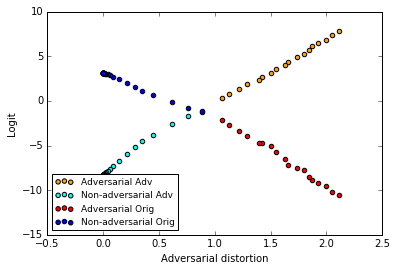

(0, 8, array([[  9.99845624e-01,   1.50231733e-06,   1.01829279e-07,
          1.38513712e-07,   6.47875176e-09,   9.24154833e-08,
          1.51792643e-04,   1.28050701e-07,   2.91317008e-07,
          2.51523829e-07]], dtype=float32))
Img 6946 Adv label 7


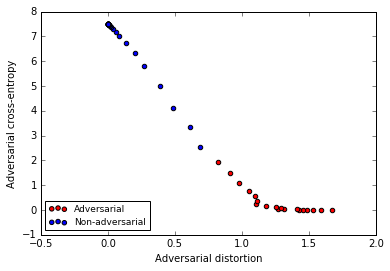

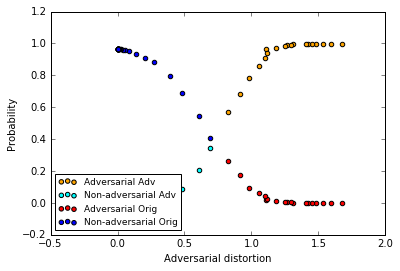

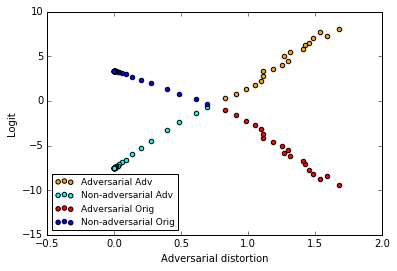

(6, 6, array([[  1.04588082e-07,   1.80138693e-09,   3.93229893e-12,
          3.80890241e-12,   5.45175545e-14,   8.42351091e-14,
          9.99999881e-01,   1.30765026e-11,   7.10390439e-15,
          1.03630689e-11]], dtype=float32))
Img 6660 Adv label 8


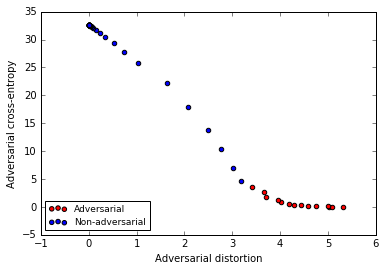

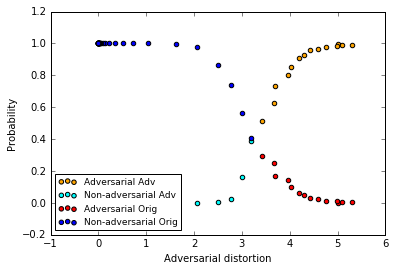

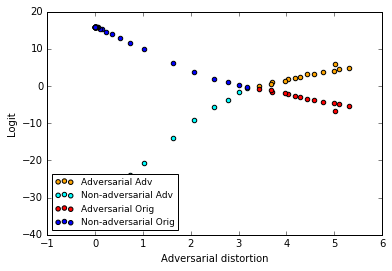

(5, 5, array([[  1.03136203e-15,   1.08388236e-18,   3.67372081e-15,
          2.97979176e-16,   1.34993527e-08,   9.99999881e-01,
          2.14293174e-21,   1.30392976e-07,   1.06397843e-17,
          4.47497317e-11]], dtype=float32))
Img 24919 Adv label 2


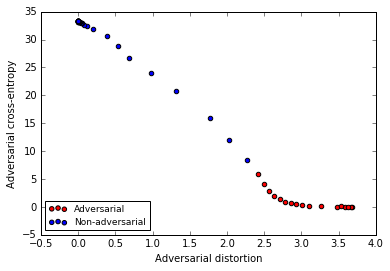

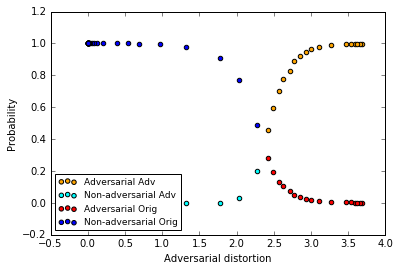

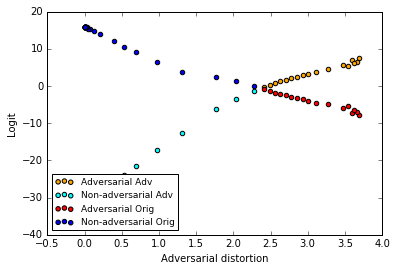

(1, 1, array([[  2.69801851e-04,   9.79586184e-01,   1.09703012e-03,
          9.96425631e-04,   1.46934690e-04,   7.28436135e-05,
          1.66588910e-02,   7.01515761e-04,   4.63430479e-04,
          7.00716828e-06]], dtype=float32))
Img 10727 Adv label 8


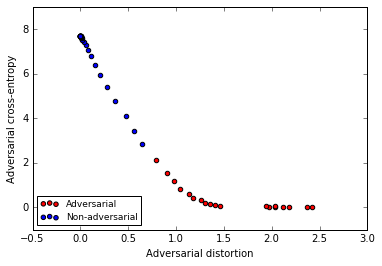

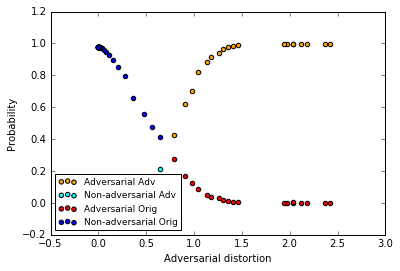

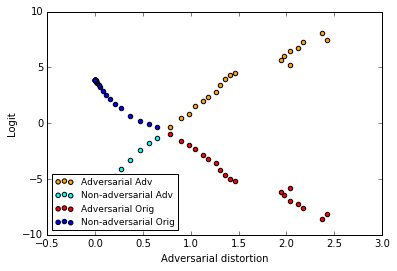

(6, 6, array([[  4.15648574e-05,   1.40421332e-06,   1.27238638e-06,
          7.03567338e-08,   1.47346291e-09,   1.19972199e-09,
          9.99955297e-01,   3.58852370e-09,   2.18277374e-09,
          3.97276011e-07]], dtype=float32))
Img 7664 Adv label 7


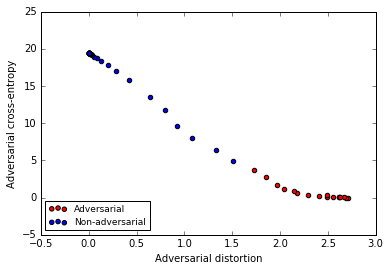

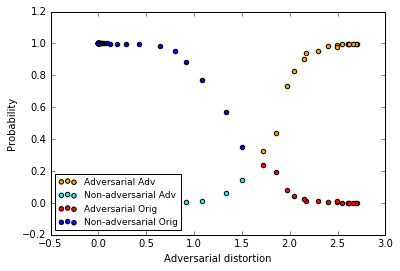

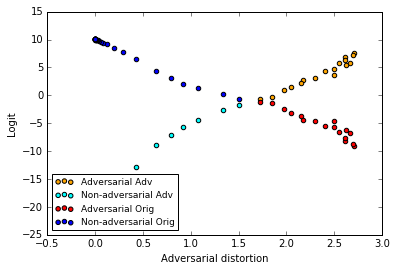

In [12]:
n = 25

adv_norm = []
adv_prob = []
orig_prob = []

for i in range(n):
    an, _, ap, op = orig_adv_dist(plot = True)
    adv_norm.append(an)
    adv_prob.append(ap)
    orig_prob.append(op)
    
adv_norm = np.array(adv_norm)
adv_prob = np.array(adv_prob)
adv_prob_logit = scipy.special.logit(adv_prob)
orig_prob = np.array(orig_prob)
orig_prob_logit = scipy.special.logit(orig_prob)

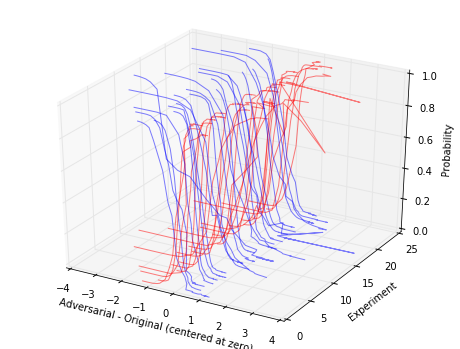

In [13]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for i in range(n):
    intersection = np.argmax((orig_prob[i] - adv_prob[i]) >= 0)
    intersection_x = (adv_norm[i][intersection-1] + adv_norm[i][intersection])/2.0
    intersection_y1 = 0#(adv_prob[i][intersection-1] + adv_prob[i][intersection])/2.0
    intersection_y2 = 0#(orig_prob[i][intersection-1] + orig_prob[i][intersection])/2.0
    ax.plot(adv_norm[i]-intersection_x, [i]*len(adv_prob[i]), adv_prob[i]-intersection_y1, color = 'r', alpha = 0.5)
    ax.plot(adv_norm[i]-intersection_x, [i]*len(adv_prob[i]), orig_prob[i]-intersection_y2, color = 'b', alpha = 0.5)

ax.set_xlabel('Adversarial - Original (centered at zero)')
ax.set_ylabel('Experiment')
ax.set_zlabel('Probability')
fig.set_figwidth(8)
fig.set_figheight(6)
plt.show()

(17, 1.2639068937713231, 0, 0)
(19, 0.84829878486165611, 0, 0)
(16, 1.732182507321016, 0, 0)
(17, 1.9951713329295762, 0, 0)
(20, 0.71084367373644519, 0, 0)
(19, 1.1079715410191913, 0, 0)
(19, 1.0020323264178677, 0, 0)
(14, 2.9896793134977293, 0, 0)
(17, 1.4764106974038693, 0, 0)
(18, 1.083966542688207, 0, 0)
(17, 1.4027331795986164, 0, 0)
(14, 3.5990338580399026, 0, 0)
(20, 0.6553941963225608, 0, 0)
(14, 2.8106873506815289, 0, 0)
(17, 1.2156140501796928, 0, 0)
(17, 1.9010783766310877, 0, 0)
(15, 2.0547680004092492, 0, 0)
(16, 1.1295632420977899, 0, 0)
(20, 0.71701658888710651, 0, 0)
(18, 0.97428515039399599, 0, 0)
(19, 0.75777292862421652, 0, 0)
(14, 3.2997761731969231, 0, 0)
(17, 2.3465518746672247, 0, 0)
(19, 0.71490746164227714, 0, 0)
(17, 1.6130330312304104, 0, 0)


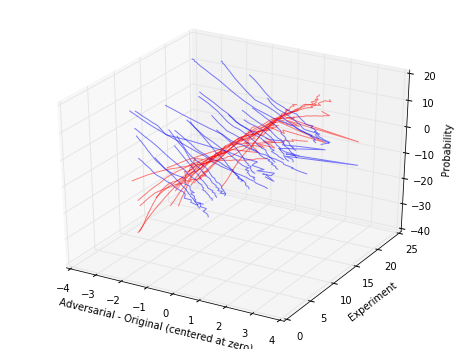

In [14]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for i in range(n):
    intersection = np.argmax((orig_prob_logit[i] - adv_prob_logit[i]) >= 0)
    intersection_x = (adv_norm[i][intersection-1] + adv_norm[i][intersection])/2.0
    intersection_y1 = 0#(adv_prob_logit[i][intersection-1] + adv_prob_logit[i][intersection])/2.0
    intersection_y2 = 0#(orig_prob_logit[i][intersection-1] + orig_prob_logit[i][intersection])/2.0
    ax.plot(adv_norm[i]-intersection_x, [i]*len(adv_prob[i]), adv_prob_logit[i]-intersection_y1, color = 'r', alpha = 0.5)
    ax.plot(adv_norm[i]-intersection_x, [i]*len(adv_prob[i]), orig_prob_logit[i]-intersection_y2, color = 'b', alpha = 0.5)

ax.set_xlabel('Adversarial - Original (centered at zero)')
ax.set_ylabel('Experiment')
ax.set_zlabel('Probability')
fig.set_figwidth(8)
fig.set_figheight(6)
plt.show()